In [1]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import random


from numpy import random
from sklearn.preprocessing import OrdinalEncoder
from IPython import display


#tf.compat.v1.disable_eager_execution()

#%matplotlib inline
random.seed(246)

In [2]:
from Preparation import *
df, cols = prep_data()

In [3]:
split_train_ratio = 0.8 #
max_journ_len = 16 #as specified in prep_data.jpynb
# Changeable Hyperparameters
num_epochs = 10
lr = 0.01
batch_size = 1000
layer1size = 32
layer2size = 32
loss = 'sparse_categorical_crossentropy'
#'mean_squared_error'
# 'binary_crossentropy'
# 'sparse_categorical_crossentropy' the most useful loss for this task


In [4]:
# Dividing the dataset into test and training data
journeys = df['journey_id'].unique()
num_train_samples = int(len(journeys) * split_train_ratio)
shuffled_journeys = np.random.permutation(journeys)
df_train = df[df['journey_id'].isin(shuffled_journeys[:num_train_samples])]
df_test = df[df['journey_id'].isin(shuffled_journeys[num_train_samples:])]

# Next step: transform to tensor

In [5]:
# Transforming the data to three dimensions according to customer journey
X_test, Y_test = mta2tensor(df_test, max_journ_len)
print("check1")
X_train, Y_train = mta2tensor(df_train, max_journ_len)
print("check2")

check1
check2


In [6]:
# Transforming data into tensor and batches
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_dataset = train_dataset.batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
test_dataset = test_dataset.batch(batch_size)

In [7]:
print('Size training data : ', len(X_train), '\nSize test data: ', len(X_test))

Size training data :  593316 
Size test data:  148330


In [8]:
# Defining some needed input values
time_steps = max_journ_len
input_dim = df_train.shape[1] - 2  # -2 weil journey_id und transaction wegfällt
num_classes = 2 # 1 for binary_loss and mse, 2 for sparse_categorical

# The Models

In [9]:
#from tensorflow import keras
from Keras_GRU import *

In [10]:
# to log train and test loss during training
class LossHistory(tf.keras.callbacks.Callback):
    def __init__(self):
        self.train_losses = []
        self.test_losses = []

    def on_epoch_end(self, epoch, logs=None):
        self.train_losses.append(logs.get('loss'))
        self.test_losses.append(logs.get('val_loss'))

## LSTM network

In [11]:
# LSTM Model for comparison

modelLSTM = tf.keras.Sequential()

modelLSTM.add(
    tf.keras.layers.LSTM(units = layer1size, input_shape=(time_steps, input_dim),
    return_sequences=True,
    return_state=False,
    go_backwards=False,
    stateful=False,
    unroll=False,
    time_major=False
    )
)
modelLSTM.add(
    tf.keras.layers.LSTM(units = layer2size,
    return_sequences=False,
    return_state=False,
    go_backwards=False,
    stateful=False,
    unroll=False,
    time_major=False
    )
)

modelLSTM.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

In [12]:
modelLSTM.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=loss, metrics=['accuracy'])

# Create instances of the custom callback
loss_history_LSTM = LossHistory()

# Train the model with the custom callback
modelLSTM.fit(train_dataset, epochs=num_epochs, batch_size=batch_size, validation_data=test_dataset, callbacks=[loss_history_LSTM])

Epoch 1/10
594/594 [==============================] - 72s 116ms/step - loss: 0.0969 - accuracy: 0.9817 - val_loss: 0.0883 - val_accuracy: 0.9821
Epoch 2/10
594/594 [==============================] - 61s 103ms/step - loss: 0.0903 - accuracy: 0.9817 - val_loss: 0.0811 - val_accuracy: 0.9821
Epoch 3/10
594/594 [==============================] - 60s 100ms/step - loss: 0.0868 - accuracy: 0.9817 - val_loss: 0.0809 - val_accuracy: 0.9821
Epoch 4/10
594/594 [==============================] - 57s 96ms/step - loss: 0.0853 - accuracy: 0.9817 - val_loss: 0.0804 - val_accuracy: 0.9821
Epoch 5/10
594/594 [==============================] - 57s 96ms/step - loss: 0.0848 - accuracy: 0.9817 - val_loss: 0.0804 - val_accuracy: 0.9821
Epoch 6/10
594/594 [==============================] - 56s 94ms/step - loss: 0.0859 - accuracy: 0.9817 - val_loss: 0.0837 - val_accuracy: 0.9821
Epoch 7/10
594/594 [==============================] - 56s 94ms/step - loss: 0.0871 - accuracy: 0.9817 - val_loss: 0.0812 - val_accura

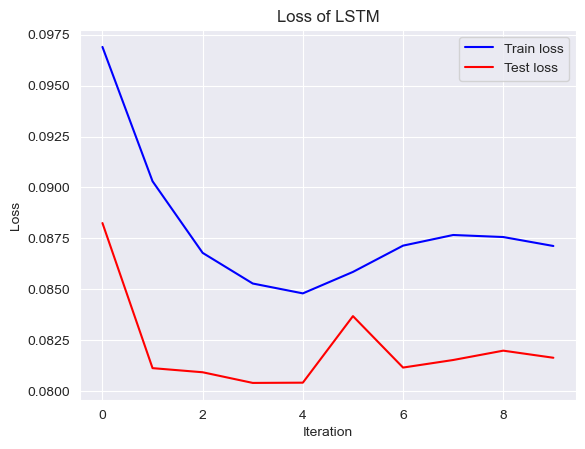

In [13]:
plt.plot(loss_history_LSTM.train_losses, '-b', label='Train loss')
plt.plot(loss_history_LSTM.test_losses, '-r', label='Test loss')
plt.legend(loc=0)
plt.title('Loss of LSTM')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

## GRU network
(also uses custom phased GRUCell, but without time gate (time_gate=False))

In [14]:
modelGRU = tf.keras.Sequential()

modelGRU.add(
    tf.keras.layers.RNN(
        phased_GRUCell(units = layer1size, input_shape=(time_steps, input_dim), time_gate=False),
        return_sequences=True,
        return_state=False,
        go_backwards=False,
        stateful=False,
        unroll=False,
        time_major=False
    )
)
modelGRU.add(
    tf.keras.layers.RNN(
        phased_GRUCell(units = layer2size, time_gate=False),
        return_sequences=False,
        return_state=False,
        go_backwards=False,
        stateful=False,
        unroll=False,
        time_major=False
    )
)

modelGRU.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

In [15]:
modelGRU.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=loss)

# Create instances of the custom callback
loss_history_GRU = LossHistory()

# Train the model with the custom callback

modelGRU.fit(train_dataset, epochs=num_epochs, batch_size=batch_size, validation_data=test_dataset, callbacks=[loss_history_GRU])

Epoch 1/10
594/594 [==============================] - 64s 103ms/step - loss: 0.0984 - val_loss: 0.0897
Epoch 2/10
594/594 [==============================] - 64s 107ms/step - loss: 0.0902 - val_loss: 0.0881
Epoch 3/10
594/594 [==============================] - 64s 107ms/step - loss: 0.0894 - val_loss: 0.0875
Epoch 4/10
594/594 [==============================] - 64s 108ms/step - loss: 0.0891 - val_loss: 0.0870
Epoch 5/10
594/594 [==============================] - 63s 106ms/step - loss: 0.0888 - val_loss: 0.0861
Epoch 6/10
594/594 [==============================] - 64s 108ms/step - loss: 0.0891 - val_loss: 0.0855
Epoch 7/10
594/594 [==============================] - 64s 108ms/step - loss: 0.0891 - val_loss: 0.0836
Epoch 8/10
594/594 [==============================] - 66s 112ms/step - loss: 0.0882 - val_loss: 0.0836
Epoch 9/10
594/594 [==============================] - 67s 113ms/step - loss: 0.0885 - val_loss: 0.0880
Epoch 10/10
594/594 [==============================] - 68s 114ms/step - l

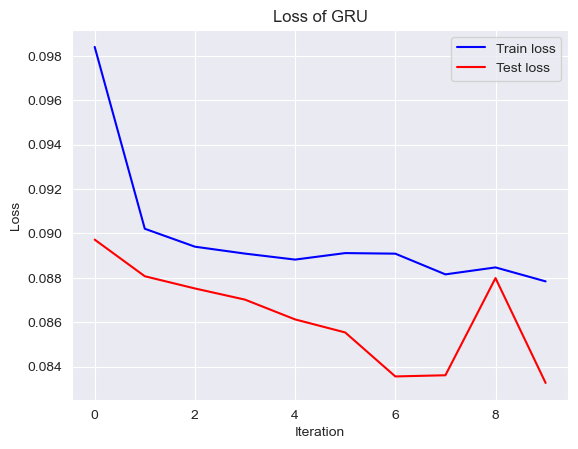

In [16]:
plt.plot(loss_history_GRU.train_losses, '-b', label='Train loss')
plt.plot(loss_history_GRU.test_losses, '-r', label='Test loss')
plt.legend(loc=0)
plt.title('Loss of GRU')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

## DIY phased GRU

In [17]:
modelphasedGRU = tf.keras.Sequential()

modelphasedGRU.add(
    tf.keras.layers.RNN(
        phased_GRUCell(units = layer1size, input_shape=(time_steps, input_dim), time_gate=True),
        return_sequences=True,
        return_state=False,
        go_backwards=False,
        stateful=False,
        unroll=False,
        time_major=False
    )
)
modelphasedGRU.add(
    tf.keras.layers.RNN(
        phased_GRUCell(units = layer2size, time_gate=True, last_layer=True),
        return_sequences=False,
        return_state=False,
        go_backwards=False,
        stateful=False,
        unroll=False,
        time_major=False
    )
)

modelphasedGRU.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

In [18]:
modelphasedGRU.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=loss)

# Create instances of the custom callback
loss_history_phasedGRU = LossHistory()

# Train the model with the custom callback

modelphasedGRU.fit(train_dataset, epochs=num_epochs, validation_data=test_dataset, callbacks=[loss_history_phasedGRU])

Epoch 1/10
594/594 [==============================] - 94s 150ms/step - loss: 0.0975 - val_loss: 0.0832
Epoch 2/10
594/594 [==============================] - 95s 161ms/step - loss: 0.0863 - val_loss: 0.0766
Epoch 3/10
594/594 [==============================] - 96s 162ms/step - loss: 0.0823 - val_loss: 0.0746
Epoch 4/10
594/594 [==============================] - 97s 164ms/step - loss: 0.0788 - val_loss: 0.0722
Epoch 5/10
594/594 [==============================] - 99s 166ms/step - loss: 0.0764 - val_loss: 0.0710
Epoch 6/10
594/594 [==============================] - 97s 164ms/step - loss: 0.0744 - val_loss: 0.0698
Epoch 7/10
594/594 [==============================] - 98s 165ms/step - loss: 0.0728 - val_loss: 0.0697
Epoch 8/10
594/594 [==============================] - 99s 167ms/step - loss: 0.0718 - val_loss: 0.0696
Epoch 9/10
594/594 [==============================] - 100s 169ms/step - loss: 0.0712 - val_loss: 0.0699
Epoch 10/10
594/594 [==============================] - 101s 169ms/step -

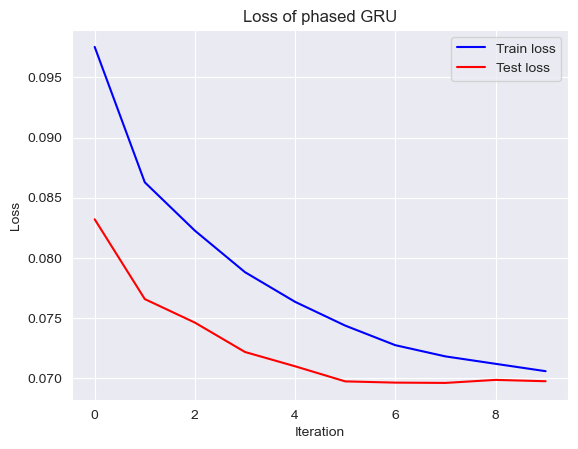

In [19]:
plt.plot(loss_history_phasedGRU.train_losses, '-b', label='Train loss')
plt.plot(loss_history_phasedGRU.test_losses, '-r', label='Test loss')
plt.legend(loc=0)
plt.title('Loss of phased GRU')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

# Comparison of models

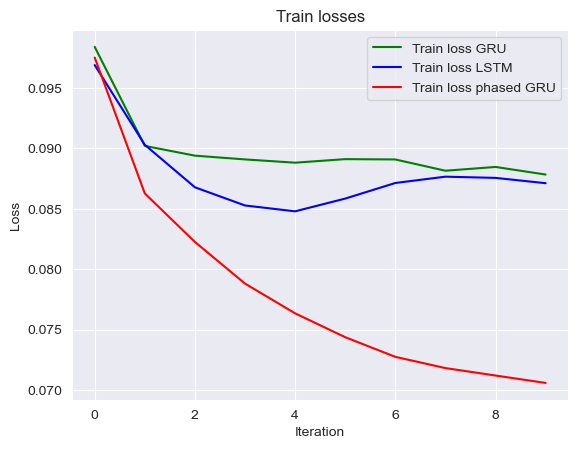

In [20]:
plt.plot(loss_history_GRU.train_losses, '-g', label='Train loss GRU')
plt.plot(loss_history_LSTM.train_losses, '-b', label='Train loss LSTM')
plt.plot(loss_history_phasedGRU.train_losses, '-r', label='Train loss phased GRU')
plt.legend(loc=0)
plt.title('Train losses')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.savefig('TrainingLosses_lossfct{}_lr{}_bs{}_l1s{}_l2s{}.png'.format(loss,lr,batch_size,layer1size,layer2size))
plt.show()

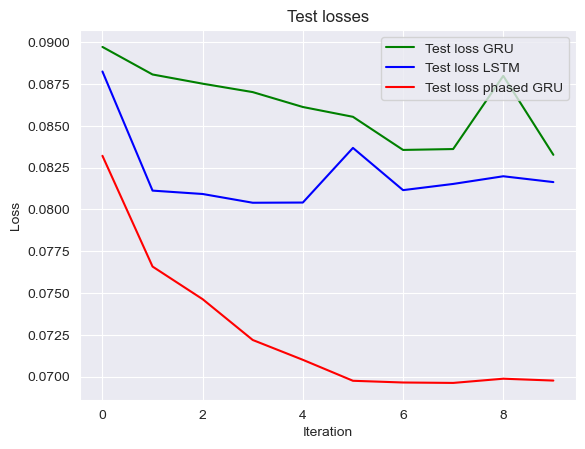

In [21]:
plt.plot(loss_history_GRU.test_losses, '-g', label='Test loss GRU')
plt.plot(loss_history_LSTM.test_losses, '-b', label='Test loss LSTM')
plt.plot(loss_history_phasedGRU.test_losses, '-r', label='Test loss phased GRU')
plt.legend(loc=0)
plt.title('Test losses')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.savefig('TestLosses_lossfct{}_lr{}_bs{}_l1s{}_l2s{}.png'.format(loss,lr,batch_size,layer1size,layer2size))
plt.show()

In [22]:
modelGRU.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rnn (RNN)                   (None, 16, 32)            28416     
                                                                 
 rnn_1 (RNN)                 (None, 32)                6336      
                                                                 
 dense_1 (Dense)             (None, 2)                 66        
                                                                 
Total params: 34,818
Trainable params: 34,818
Non-trainable params: 0
_________________________________________________________________


In [23]:
modelphasedGRU.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rnn_2 (RNN)                 (None, 16, 32)            28390     
                                                                 
 rnn_3 (RNN)                 (None, 32)                6310      
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 34,766
Trainable params: 34,766
Non-trainable params: 0
_________________________________________________________________


In [24]:
modelLSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 16, 32)            37760     
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 2)                 66        
                                                                 
Total params: 46,146
Trainable params: 46,146
Non-trainable params: 0
_________________________________________________________________


In [25]:
# Save optimized model after Hyperparametertuning
'''
modelGRU.save('GRUmodel')
modelphasedGRU.save('phasedGRUmodel')

cols = cols.drop(['timestamp','transaction','journey_id'])
text_file = open('cols.txt', 'w')
for i in cols:
    text_file.write(i + '\n')
text_file.close()
#reloaded_modelGRU = tf.keras.models.load_model('GRUmodel')
#reloaded_modelphasedGRU = tf.keras.models.load_model('phasedGRUmodel')
'''

"\nmodelGRU.save('GRUmodel')\nmodelphasedGRU.save('phasedGRUmodel')\n\ncols = cols.drop(['timestamp','transaction','journey_id'])\ntext_file = open('cols.txt', 'w')\nfor i in cols:\n    text_file.write(i + '\n')\ntext_file.close()\n#reloaded_modelGRU = tf.keras.models.load_model('GRUmodel')\n#reloaded_modelphasedGRU = tf.keras.models.load_model('phasedGRUmodel')\n"

In [26]:
# evaluate accuracy??
modelLSTM.evaluate(test_dataset)
modelGRU.evaluate(test_dataset)
modelphasedGRU.evaluate(test_dataset)

149/149 [==============================] - 8s 51ms/step - loss: 0.0698


0.06976703554391861

In [27]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score


In [ ]:
#all based on sparse_categorical_crossentropy loss and two classes
y_pred_lstm = modelLSTM.predict(X_test)
y_pred_gru = modelGRU.predict(X_test)
y_pred_phasedgru = modelphasedGRU.predict(X_test)

In [ ]:
auc_lstm = roc_auc_score(Y_test, y_pred_lstm[:,-1])
auc_gru = roc_auc_score(Y_test, y_pred_gru[:,-1])
auc_phasedgru = roc_auc_score(Y_test, y_pred_phasedgru[:,-1])
print('AUC for LSTM: {}\nAUC for GRU: {}\nAUC for phased_GRU: {}'.format(auc_lstm,auc_gru,auc_phasedgru))

In [ ]:
fpr, tpr, _ = roc_curve(Y_test, y_pred_lstm[:,-1])
plt = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_lstm)
#plt.title('ROC of LSTM')
plt.plot()

In [ ]:
fpr, tpr, _ = roc_curve(Y_test, y_pred_gru[:,-1])
plt = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_gru)
#plt.title('ROC of GRU')
plt.plot()

In [ ]:
fpr, tpr, _  = roc_curve(Y_test, y_pred_phasedgru[:,-1])
plt = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_phasedgru)
#plt.title('ROC of phasedGRU')
plt.plot()

# Explanations


In [ ]:
y_pred_phasedgru[:,1]

In [ ]:
# is prediction 1?
print('expected outcome test: ', sum(Y_test)/len(Y_test), '\nexpected outcome train: ',sum(Y_train)/len(Y_train))

# Shapleyvalues

In [ ]:
import shap
#from keras import utils
#from sklearn.preprocessing import StandardScaler
#from sklearn.neural_network import MLPRegressor
#from sklearn.pipeline import make_pipeline

#from sklearn.datasets import load_diabetes
#from sklearn.model_selection import train_test_split

In [ ]:
#keras.utils.plot_model(modelLSTM, "my_first_model_with_shape_info.png")

In [ ]:
# data as tensors unbatched/sliced
x_train = np.array(X_train)
x_test = np.array(X_test)

In [ ]:
x_test[0:3].shape

In [ ]:
explainer = shap.DeepExplainer(modelLSTM, x_train[:20])

In [ ]:
tf.__version__

In [ ]:
explainer

In [ ]:
shap_values = explainer.shap_values(x_test[:20])

In [ ]:
shap.initjs()
shap.force_plot(explainer, shap_values)

In [ ]:
explainer = shap.Explainer(modelLSTM)

# Prepare a sample input data point (sequence) for explanation
#sample_input = np.array([[...]])  # Replace with your input data

# Calculate Shapley values for the sample input
shap_values = explainer(, max_evals=4000)

# Print or visualize the SHAP values to interpret the model's output
shap.summary_plot(shap_values)

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], x_test[0:3])

In [ ]:
#shap.summary_plot(shap_values,x_test)
#shap.initjs()
#shap.force_plot(explainer.expected_value, shap_values[0,:]  ,x_test[0,:])